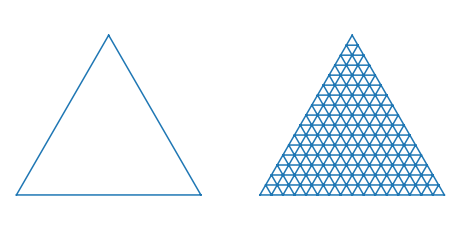

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

In [2]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])

def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math
    
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.text(0.4,0.9,'class 1')
    plt.text(1,-0.05,'class 2')
    plt.text(-0.15,-0.05,'class 0')

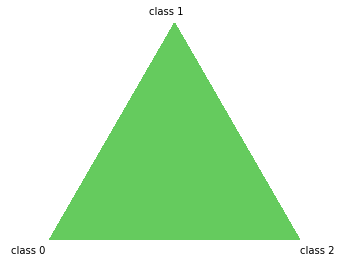

In [3]:
draw_pdf_contours(Dirichlet([1, 1, 1]))

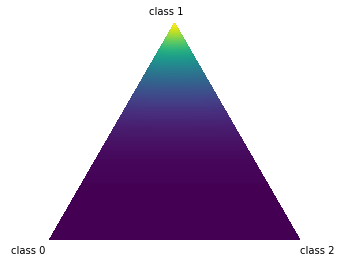

In [4]:
draw_pdf_contours(Dirichlet([1.01,1.01,5]))

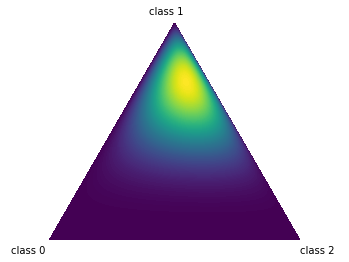

In [5]:
draw_pdf_contours(Dirichlet([1.5,2,5]))

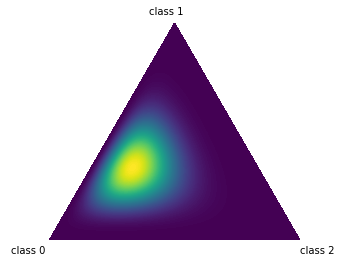

In [109]:
draw_pdf_contours(Dirichlet([7,3,5]))

In [119]:
alpha_sum=10
def iters():
    for a1 in np.linspace(1,8,100):
        for a2 in np.linspace(1, 10-a1-1,100):
            alpha = np.array([a1,a2,10-a1-a2])
            alpha0 = alpha.sum()
            alpha_hat = alpha/alpha0
            delta = np.eye(3)
            cov_mtx = (delta*alpha_hat[:,None]-alpha_hat[:,None]*alpha_hat[None,:])/(alpha0+1)
            # print(cov_mtx)
            import torch
            alpha = torch.tensor(alpha[None,:])
            alpha0 = torch.tensor(alpha0)
            lnB = torch.sum(torch.lgamma(alpha), dim=1, keepdim=True) - torch.lgamma(alpha0)
            H = lnB+(alpha0-3)*torch.digamma(alpha0)-torch.sum((alpha-1)*torch.digamma(alpha),dim=1,keepdim=True)
            # print(H)
            yield(np.mean(np.abs((1-delta)*cov_mtx)), alpha)

a = iters()
values, ids = zip(*a)
ids[np.argmin(values)]

tensor([[1., 1., 8.]], dtype=torch.float64)

In [116]:
alpha = np.array([1,1,8])
alpha0 = alpha.sum()
alpha_hat = alpha/alpha0
delta = np.eye(3)
cov_mtx = (delta*alpha_hat[:,None]-alpha_hat[:,None]*alpha_hat[None,:])/(alpha0+1)
# print(cov_mtx)
import torch
alpha = torch.tensor(alpha[None,:])
alpha0 = torch.tensor(alpha0)
lnB = torch.sum(torch.lgamma(alpha), dim=1, keepdim=True) - torch.lgamma(alpha0)
H = lnB+(alpha0-3)*torch.digamma(alpha0)-torch.sum((alpha-1)*torch.digamma(alpha),dim=1,keepdim=True)
# print(H)
np.mean(np.abs((1-delta)*cov_mtx))

0.003434343434343435

In [76]:
0.006506899055918664

In [92]:
0.006235827664399093

tensor([[-17.1786]], dtype=torch.float64)

In [103]:
0.006382992070661449

0.006235827664399093